# EIT-CEM - Experimental Data EXP-1.2

In [6]:
#Fixing paths
import sys
sys.path.append('../../FEIT_codes') # Add the parent directory to the path list

#Importing modules
from FEIT_onefile import *
from math import pi
import scipy
%matplotlib inline
import time
import seaborn as sns
sns.set_context("talk")

## Mesh

In [7]:
"Definições Básicas do espaço."
r=14            #Radi
L=16           #Number of Electrodes
per_cober=0.454728409  #Perc. area of elec. on boundary
rotate=pi/2-0.0892857143183109       #Rotation

ele_pos=electrodes_position(L, per_cober, rotate, anticlockwise=False) #Eletrodes position object

## Checking electrode dimension

In [8]:
i=0
thetai=(ele_pos.position[i][0])
thetaf=(ele_pos.position[i][1])
elec_lenght=(thetaf-thetai)*r
print("Electrode {} lenght is: {} cm".format(i, elec_lenght))

Electrode 0 lenght is: 2.500000000912705 cm


Number of cells:  1200


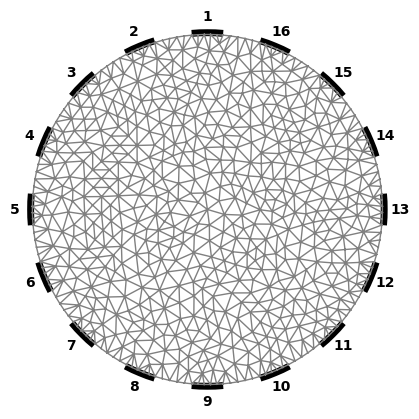

In [9]:
#input
refine_n=15 #Refinement parameter
n_in=6   #Number of vertex on electrodes
n_out=4   #Number of vertex on gaps

mesh=MyMesh(r=r, n=refine_n, n_in=n_in, n_out=n_out, electrodes_obj=ele_pos)
plot_electrodes(mesh, figsize=(5,5), fontsize=10)
print("Number of cells: ", mesh.num_cells())

In [10]:
#Load experimental data
dataname = "datamat/datamat_1_2.mat"
mat = scipy.io.loadmat(dataname)
Uel=mat.get("Uel").T
CP=mat.get("CurrentPattern").T

In [11]:
#Selecting Potentials
Uel_f=Uel[64:] #Matrix of measuarements
Uel_converted=np.zeros_like(Uel_f)

#Convert type of data
for index, potential in enumerate(Uel_f): 
    Uel_converted[index]=ConvertingData(potential, method="KIT4")
list_U0=Uel_converted.flatten() #Matrix to vector

#Current
I_all=CP[64:]/sqrt(2)
l=np.shape(I_all)[0] #Number of experiments = 15

#Noise Estiamtive
delta = EstimateDelta(list_U0, I_all)
noise_level_exp = delta/np.linalg.norm(list_U0)*100
print("Noise level (%): ", noise_level_exp)

Noise level (%):  0.4235990100461563


## Inverse Problem

In [20]:
"Object"
VD=FiniteElement('CG',mesh.ufl_cell(),1) #Espaço da solução
z=np.ones(L)*0.07825
cond=0.92959

InverseObject=InverseProblem(mesh, list_U0, I_all, z)

"Solver Parameters"
InverseObject.set_solverconfig(step_limit=60, innerstep_limit=500)
InverseObject.set_NewtonParameters(mu_i=0.7, mumax=0.999, nu=0.97, R=0.97)
InverseObject.set_InnerParameters(inner_method='Tikhonov', Tik_c0=0.001, Tik_q=1)
#InverseObject.set_InnerParameters(inner_method='Landweber', land_a=0.3)
#InverseObject.set_InnerParameters(inner_method='ME', ME_reg=1E-4)
#InverseObject.set_InnerParameters(inner_method='CG')
#InverseObject.set_InnerParameters(inner_method='LM', LM_c0=0.1, LM_q=0.3)

"Noise Parameters"
tau=1.1
noise_level=noise_level_exp/100#/((1+eta)/(1-eta))
InverseObject.set_NoiseParameters(tau, noise_level)
print("Discrepance stop {:.2f}% residue, tau={:.2f}".format(tau*noise_level*100, tau))

InverseObject.weight_value=False

guess_r=np.ones(mesh.num_cells())
InverseObject.set_firstguess(guess_r*cond)

Discrepance stop 0.47% residue, tau=1.10


In [21]:
InverseObject.solve_inverse()


Residue (%)= 15.006203030234325  step: 0 Inner step:  0
mu_n 0.7
Residue (%)= 4.059788294213535  step: 1 Inner step:  1
mu_n 0.7
Residue (%)= 1.906321153617395  step: 2 Inner step:  1
mu_n 0.6992999999999999
Residue (%)= 1.3002830460265946  step: 3 Inner step:  3
mu_n 0.8988668999999999
Residue (%)= 1.1692835513790059  step: 4 Inner step:  1
mu_n 0.8710289921069998
Residue (%)= 0.9827825601963056  step: 5 Inner step:  3
mu_n 0.844053224221446
Residue (%)= 0.8303808145925651  step: 6 Inner step:  5
mu_n 0.9055255025983348
Residue (%)= 0.740465692229252  step: 7 Inner step:  5
mu_n 0.9046199770957364
Residue (%)= 0.6667067698027541  step: 8 Inner step:  7
mu_n 0.930939540799029
Residue (%)= 0.6215197688477061  step: 9 Inner step:  6
mu_n 0.9185100348012684
Residue (%)= 0.5735366668463157  step: 10 Inner step:  11
mu_n 0.8900637790234731
Residue (%)= 0.532843791243328  step: 11 Inner step:  25
mu_n 0.9506764347075578
Residue (%)= 0.5065516569117046  step: 12 Inner step:  3
mu_n 0.92123398

## Results

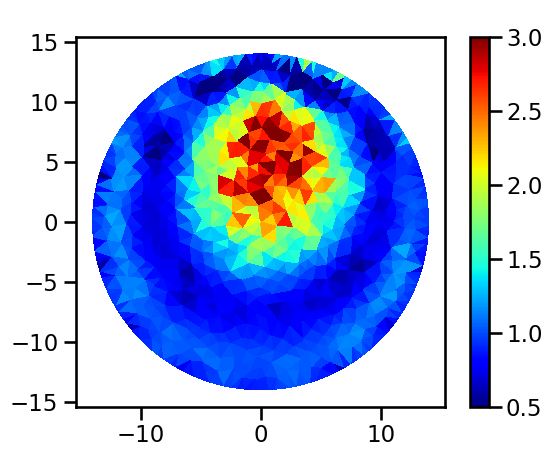

In [43]:
#Plot
Q_DG = FunctionSpace(mesh, "DG", 0)
gamma_k = Function(Q_DG)

gamma_k_vec=np.copy(InverseObject.gamma_all[-1])
for i in range(len(gamma_k_vec)):
    if gamma_k_vec[i]<=0.5: gamma_k_vec[i]=0.5
    if gamma_k_vec[i]>=3: gamma_k_vec[i]=3
gamma_k.vector()[:]=gamma_k_vec#-np.log(gamma_k_vec)/np.log(cond)
gamma_k=plot_figure(gamma_k, name=" ", map='jet')

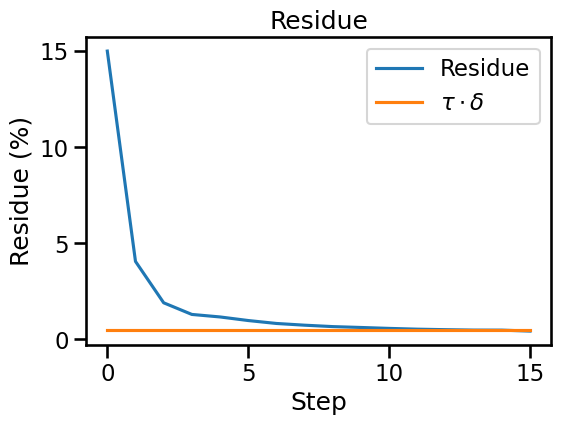

In [42]:
#Residue Curve
res=np.copy(InverseObject.res_vec)

plt.figure(figsize=(6, 4))
plt.ylabel('Residue (%)');
plt.xlabel('Step');
plt.title('Residue');
plt.plot()
plt.plot(res, label="Residue");
plt.plot(np.ones(len(res))*tau*noise_level*100, label=r"$\tau \cdot \delta$");
plt.legend()
#plt.savefig("figures/{}/Residue.png".format(exp_name))
plt.show()